### PySpark Tutorial

from https://www.youtube.com/watch?v=B-x58mOUEbw
<br> Spark DataFrame Operations and Transformations
<br> by  Radu Fotolescu
<br> https://www.decisionforest.com

Download data: 
https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#single-file

In [1]:
# %load_ext nb_black
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(style="seaborn")
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession, Window
from pyspark import SparkConf
import pyspark.sql.functions as F
from pyspark.sql import types as T

spark = SparkSession.builder.appName("UK Property Analysis").getOrCreate()
spark

22/07/09 20:47:52 WARN Utils: Your hostname, MacBook-M1-Pro-16-Lev-2022.local resolves to a loopback address: 127.0.0.1; using 192.168.0.34 instead (on interface en0)
22/07/09 20:47:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/09 20:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# download file from here
# 'http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2022.csv'
data = spark.read.csv("data/pp-2022.csv", inferSchema=True, header=True)

In [4]:
data.count()

161803

In [5]:
data = data.toDF(
    "Transaction ID",
    "Price",
    "Date",
    "Postcode",
    "Property Type",
    "New Build",
    "Estate Type",
    "Building Name/Nr",
    "Column_8",
    "Street",
    "Column_10",
    "Town",
    "District",
    "County",
    "Column_14",
    "Column_15",
)

In [6]:
data.show(2)

22/07/09 20:48:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: {DE2D0CE0-1D92-51EE-E053-6C04A8C00671}, 230000, 2022-03-14 00:00, CR0 1AB, F, N, L, LION HEAD COURT, 17, FLAT 4, ST ANDREWS ROAD, , CROYDON, CROYDON, GREATER LONDON, A, A
 Schema: {DE2D0CE0-1D92-51EE-E053-6C04A8C00671}, 230000, 2022-03-14 00:00, CR0 1AB, F, N, L, LION HEAD COURT, 17, FLAT 4, ST ANDREWS ROAD, _c10, CROYDON11, CROYDON12, GREATER LONDON, A14, A15
Expected: _c10 but found: 
CSV file: file:///Users/levselector/Documents/GitHub/python_tutorials/files/pp-2022.csv
+--------------------+------+-------------------+--------+-------------+---------+-----------+-----------------+--------+----------+---------+---------+--------------------+--------------+---------+---------+
|      Transaction ID| Price|               Date|Postcode|Property Type|New Build|Estate Type| Building Name/Nr|Column_8|    Street|Column_10|     Town|            District|        County|Column_14|Column_15|
+----------

### Data Resampling

In [7]:
data.select("Date").dtypes

[('Date', 'timestamp')]

In [8]:
data.select("Date").take(1)

[Row(Date=datetime.datetime(2022, 1, 21, 0, 0))]

In [9]:
data = data.withColumn("Date", F.to_timestamp(data.Date, "yyyy-MM-dd 00:00"))

In [10]:
data.select("Price").dtypes

[('Price', 'int')]

In [11]:
data = data.withColumn("Price", data.Price.cast("float"))

In [12]:
data.select("Date").take(1)

[Row(Date=datetime.datetime(2022, 1, 21, 0, 0))]

In [13]:
assert data.groupBy("Transaction ID").count().count() == data.count()

In [14]:
sub = data.groupBy("Date", F.window("Date", "30 days")).agg(
    F.expr("collect_list(Price)").alias("Prices"),
    F.expr("count('Transaction ID')").alias("Count"),
)

In [15]:
sub.show(2)

+-------------------+--------------------+--------------------+-----+
|               Date|              window|              Prices|Count|
+-------------------+--------------------+--------------------+-----+
|2022-01-01 00:00:00|{2021-12-28 19:00...|[325000.0, 160000...|   32|
|2022-01-02 00:00:00|{2021-12-28 19:00...|[418000.0, 120000...|    8|
+-------------------+--------------------+--------------------+-----+
only showing top 2 rows



In [16]:
sub.select("window").take(1)

[Row(window=Row(start=datetime.datetime(2021, 12, 28, 19, 0), end=datetime.datetime(2022, 1, 27, 19, 0)))]

In [17]:
sub = sub.select("Date", "window.*", "Prices", "Count").sort(F.asc("end"))

In [18]:
sub.show(5)

+-------------------+-------------------+-------------------+--------------------+-----+
|               Date|              start|                end|              Prices|Count|
+-------------------+-------------------+-------------------+--------------------+-----+
|2022-01-01 00:00:00|2021-12-28 19:00:00|2022-01-27 19:00:00|[325000.0, 160000...|   32|
|2022-01-02 00:00:00|2021-12-28 19:00:00|2022-01-27 19:00:00|[418000.0, 120000...|    8|
|2022-01-03 00:00:00|2021-12-28 19:00:00|2022-01-27 19:00:00|[415000.0, 893225...|    8|
|2022-01-04 00:00:00|2021-12-28 19:00:00|2022-01-27 19:00:00|[205000.0, 450000...|  442|
|2022-01-05 00:00:00|2021-12-28 19:00:00|2022-01-27 19:00:00|[640000.0, 270000...| 1287|
+-------------------+-------------------+-------------------+--------------------+-----+
only showing top 5 rows



In [19]:
sub.count()

144

In [20]:
sub = sub.groupBy("end").agg(
    F.expr("collect_list(Prices)").alias("Prices"),
    F.expr("sum(Count)").alias("Count"),
)

In [21]:
sub.show(5)

+-------------------+--------------------+-----+
|                end|              Prices|Count|
+-------------------+--------------------+-----+
|2022-01-27 19:00:00|[[325000.0, 16000...|30476|
|2022-02-26 19:00:00|[[146000.0, 27575...|59427|
|2022-03-28 20:00:00|[[635000.0, 74000...|42653|
|2022-04-27 20:00:00|[[100000.0, 70000...|23699|
|2022-05-27 20:00:00|[[146100.0, 12500...| 5547|
+-------------------+--------------------+-----+
only showing top 5 rows



### UDFs
User-Defined Functions (UDFs) are functions that are applied on rows. 
They require to be registered as UDFs.

In [22]:
def unpack_list(t):
    return list(set([item for sublist in t for item in sublist]))


unpack_list_udf = F.udf(unpack_list, T.ArrayType(T.FloatType()))

In [23]:
sub = sub.withColumn("Prices", unpack_list_udf(F.col("Prices")))

In [24]:
sub.show(2)

+-------------------+--------------------+-----+
|                end|              Prices|Count|
+-------------------+--------------------+-----+
|2022-01-27 19:00:00|[106500.0, 213000...|30476|
|2022-02-26 19:00:00|[106500.0, 196614...|59427|
+-------------------+--------------------+-----+
only showing top 2 rows




[Stage 45:>                                                         (0 + 1) / 1]



In [25]:
mean_udf = F.udf(lambda x: float(np.mean(x)), T.FloatType())
median_udf = F.udf(lambda x: float(np.median(x)), T.FloatType())

In [26]:
sub = (
    sub.withColumn("Mean", mean_udf("Prices"))
    .withColumn("Median", median_udf("Prices"))
    .drop("Prices")
)

In [27]:
sub.show()

+-------------------+-----+---------+--------+
|                end|Count|     Mean|  Median|
+-------------------+-----+---------+--------+
|2022-01-27 19:00:00|30476| 719908.0|344750.0|
|2022-02-26 19:00:00|59427| 723439.5|345850.0|
|2022-03-28 20:00:00|42653|691317.75|340250.0|
|2022-04-27 20:00:00|23699|770007.06|363050.0|
|2022-05-27 20:00:00| 5547|539958.75|322580.0|
|2022-06-26 20:00:00|    1| 160000.0|160000.0|
+-------------------+-----+---------+--------+



In [28]:
sub = sub.toPandas()

In [29]:
sub

,end,Count,Mean,Median
0,2022-01-27 19:00:00,30476,719908.0000,344750.0
1,2022-02-26 19:00:00,59427,723439.5000,345850.0
2,2022-03-28 20:00:00,42653,691317.7500,340250.0
3,2022-04-27 20:00:00,23699,770007.0625,363050.0
4,2022-05-27 20:00:00,5547,539958.7500,322580.0
5,2022-06-26 20:00:00,1,160000.0000,160000.0


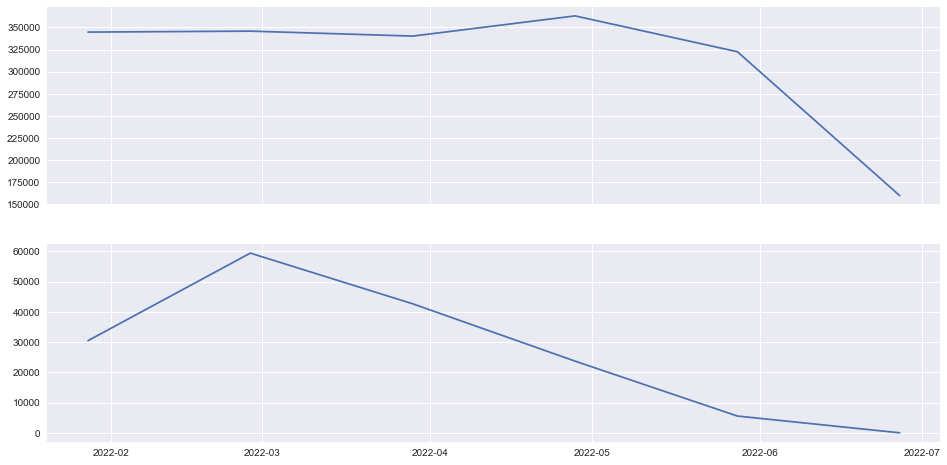

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,8))
plt.subplot(211)
plt.plot(sub['end'],sub['Median'])
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(212)
plt.plot(sub['end'],sub['Count'])
plt.ticklabel_format(style='plain', axis='y')
